# Assignment No 2
## Paper Number 7
## Title: *A simple model of global cascades on random networks*


## 📘 Summary of the Paper

**Author**: Duncan J. Watts  
**Published in**: Proceedings of the National Academy of Sciences (PNAS), 2002

---

### 🎯 Objective

The paper introduces a simple model to explain how **small initial shocks** can lead to **large-scale cascades** (chain reactions) in complex systems—such as social influence, financial crashes, or power grid failures—despite those systems being seemingly stable.

---

### 🔧 The Model

- The system is modeled as a **sparse random network** of agents (nodes).
- Each node makes a **binary decision** (active/inactive) based on the decisions of its neighbors.
- Nodes adopt the active state when a **threshold fraction (θ)** of their neighbors are already active.
- Both node **degree (number of connections)** and **thresholds** can be heterogeneous (vary between nodes).

---

### ⚙️ Dynamics

1. Initially, all nodes are inactive.
2. A small seed fraction is activated.
3. At each step, nodes check if the fraction of active neighbors ≥ their threshold.
4. Activated nodes stay active; the process continues until equilibrium.

---

### 🔍 Key Results

- There exists a **“cascade window”**: a range of average degrees `z` where **global cascades** (large activations) are likely.
- **Two regimes** for cascade propagation:
  - **Low-connectivity regime**: Cascades are limited by network structure; cascade sizes follow a **power law**.
  - **High-connectivity regime**: Cascades are limited by node stability; cascade sizes become **bimodal**—mostly small, but sometimes massive.
- **Vulnerable nodes** (those that can be triggered by a single neighbor) are crucial. If they form a connected cluster, global cascades are possible.
- **Network heterogeneity**:
  - High **threshold heterogeneity** (variability in θ) increases cascade risk.
  - High **degree heterogeneity** (variability in connections) decreases cascade risk overall—but **targeting high-degree nodes** can increase the chance of triggering cascades.

---

### 🧠 Implications

This model explains real-world phenomena such as:
- Viral marketing and social fads
- Infrastructure breakdowns
- Financial system collapses
- Coordination problems in social and political systems

It highlights the **fragile stability** of many networks: they appear robust but can be tipped into global failure by tiny, unpredictable shocks.

---

### 📌 Conclusion

The study shows that **complex cascades can emerge from simple local rules**, depending on the **network structure** and **individual thresholds**. It lays foundational work for understanding cascading behavior in social, economic, and technological networks.



------------------------------
Code to make initialization easier, can be ignored since requirements.txt is not handed in.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Import Dependancies
This part of the code imports necessary Python libraries for the implementation of the Naming Game model:

- Mesa: An agent-based modeling framework that provides a structure for implementing the model
- NumPy: For numerical operations and array handling
- Pandas: For data manipulation and analysis
- Seaborn: For statistical data visualization
- Matplotlib: For creating plots and graphs
- Random: For generating random values and selections
- Scipy: Installed as part of Mesa and used later to fit certain distributions to histogram bins.

In [2]:
#!/usr/bin/env python3.11
!python --version

import mesa
print(f"mesa version: {mesa.__version__}")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import networkx as nx

DEBUGSTEP = False
DEBUGMODEL = False

Python 3.12.10
mesa version: 3.2.0


Create random Graph

In [3]:
# code for random graph

### 🧠 GraphAgent Class: Agent Behavior in Watts' Cascade Model (Mesa)

This class defines an agent (`GraphAgent`) for use in a Mesa simulation of the cascade model.

Each agent represents a node in a network and follows the **threshold activation rule** described in Watts' paper. The behavior of the agent includes:

- **Initialization**:
  - The agent has a binary `state` (0 = inactive, 1 = active).
  - Each agent is assigned a threshold `θ` drawn from a probability distribution (e.g., uniform).

- **Step Behavior**:
  - If the agent is already active, it does nothing.
  - If inactive, it checks how many of its neighbors are active.
  - If the fraction of active neighbors exceeds its threshold, it switches to the active state.
  - This simulates **local decision-making with externalities**, as in the cascade model.

- **Additional Properties**:
  - `neighbor_amount`: Utility to return the node’s degree (number of neighbors).


This agent class models the core dynamics behind **information cascades** and helps simulate how behavior spreads through a network.


In [26]:
from mesa import Agent

# code for agents
class GraphAgent(Agent):
    def __init__(self, model, threshold_dist):
        super().__init__(model)
        self.state = 0
        self.theta = threshold_dist()

    def step(self):
        if self.state == 1:
            return
        # get neighbors and if a certain percentage is above a chosen threshold change state
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        if not neighbors:
            return
        changed_state_amount = sum([1 for neighbor in neighbors if neighbor.state == 1])
        percentage_changed = changed_state_amount / len(neighbors)
        if percentage_changed > self.theta:
            self.state = 1

    @property
    def neighbor_amount(self):
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        if neighbors:
            return len(neighbors)
        else:
            return 0

### 🧩 GraphModel Class: Network-Based Cascade Simulation with Mesa

This class defines the overall simulation model using **Mesa**, built to implement Watts' model of global cascades on a sparse random network.

---

### ⚙️ Core Components:

- **Graph Construction**:
  - If no custom graph is provided, the model generates a **random graph** (`fast_gnp_random_graph`) using NetworkX.
  - The graph is controlled via the `avg_degree` parameter, which determines the probability `p_uniform` of an edge existing between nodes.

- **Network Grid**:
  - The model uses `NetworkGrid`, which allows agents to be placed on graph nodes and access their neighbors.

- **Agent Initialization**:
  - For each node, a `GraphAgent` is created and placed on the corresponding graph node.
  - Agents are initialized with a `starting_state` (0 = inactive) and a randomly drawn threshold from `threshold_dist`.

---

### 🔁 Model Step Function:

- The `step()` function performs one timestep:
  - Agents are shuffled and each performs a `step()` (decision update).
  - State data is collected using `DataCollector` for tracking model statistics.

---

### 💥 Perturbation:

- The method `perturb_agents(theta)` activates a fraction `θ` of randomly selected agents to simulate the **initial shock or seed** that may trigger a cascade.

---

### 📊 Monitored Properties (Data Collection):

- `total_average_state`: Average activation state across all agents (fraction active).
- `empirical_threshold`: Average threshold across the agent population.
- `empirical_degrees`: Average number of neighbors (i.e., average node degree).
- `Activated_Nodes`: Number of agents that are in state 1 (aka activated).

---

This model enables simulation of **contagion dynamics**, tracking how local decisions lead to global behavioral cascades. It ties directly to the theoretical framework in Watts' 2002 paper, and allows for measuring empirical cascade conditions and phase transitions in a dynamic, agent-based setup.


In [28]:
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa import Model
from random import sample

# code for model
class GraphModel(Model):
    def __init__(self, threshold_dist, num_nodes=20, avg_degree=2, graph=None, p_k=None, seed=None):
        super().__init__(seed=seed)
        self.avg_degree = avg_degree
        self.num_agents = num_nodes
        if graph is None or p_k is None:
            raise ValueError("Graph and degree probability required to initialize model!")
        self.G = graph
        self.p_uniform = p_k
        self.grid = NetworkGrid(self.G)

        # Create an agent for each node
        GraphAgent.create_agents(model=self, n=num_nodes, threshold_dist=threshold_dist)
        for i, agent in enumerate(self.agents):
            self.grid.place_agent(agent, i)
            
        self.datacollector = DataCollector(
            model_reporters={"Total_average_State": "total_average_state",
                             "Empirical_mean": "empirical_threshold",
                             "Empirical_degrees":"empirical_degrees", 
                             "Activated_Nodes": "activated_nodes"}
        )

    def step(self):
        self.agents.shuffle_do("step")
        #self.agents.do("advance")
        self.datacollector.collect(self)
        
    def perturb_agents(self, theta):
        perturb_amount = max(int(self.num_agents * theta), 1)
        chosen_agents = sample(self.agents, perturb_amount)
        for agent in chosen_agents:
            agent.state = 1
        
    @property
    def total_average_state(self):
        return np.mean([a.state for a in self.agents])
    
    @property
    def activated_nodes(self):
        return sum([1 for agent in self.agents if agent.state == 1])
    
    @property
    def empirical_threshold(self):
        return np.mean([a.theta for a in self.agents])
    
    @property
    def empirical_degrees(self):
        return np.mean([a.neighbor_amount for a in self.agents])

### ▶️ run_model Function: Execute a Full Cascade Simulation

This function runs a full simulation of the **Watts cascade model** using the previously defined `GraphModel` class. It acts as a controller that initializes the model, perturbs the system, steps it forward over time, and collects results.

---

### 🔧 Function Parameters:

- `N`: Number of agents (nodes in the network).
- `D`: Average degree (used to compute edge probability).
- `t`: Number of timesteps to simulate.
- `starting_state`: Initial state of each agent (typically `0` = inactive).
- `threshold_dist`: A function for drawing agent threshold values (e.g., `random.uniform(0,1)`).
- `iteration`: Integer label to track or print simulation progress.
- `p_perturb`: Fraction of nodes to activate initially (seed nodes).
- `graph`: Optional custom NetworkX graph (if not provided, a random graph is generated).

---

### 🧠 Function Workflow:

1. **Model Initialization**:
   - Creates a `GraphModel` instance with the specified number of nodes and average degree.

2. **Perturbation**:
   - Activates a small percentage (`p_perturb`) of randomly chosen agents to simulate an initial shock.

3. **Simulation Loop**:
   - Runs the model for `t` timesteps, optionally printing debug output at 10% intervals.
   - Agents update their state in each step according to the threshold cascade rule.

4. **Data Collection**:
   - Returns a DataFrame of collected model statistics (e.g., cascade size over time),
     the graph object, and the final model state.

---

This function encapsulates the **entire cascade simulation process** and allows for easy repetition over multiple iterations, making it suitable for batch experiments, sensitivity analysis, or parameter sweeps.


In [6]:
def run_model(N, D, t, threshold_dist, iterations, p_perturb, graph=None, p_k=None, record_cascade=False):
    #TODO add cascade size per iteration run
    model_df = pd.DataFrame()
    agent_states = np.zeros(N)
    cascade_sizes = []
    for iteration in range(iterations):
        model = GraphModel(threshold_dist, N, D, graph, p_k)
        modulo = max(1, int(t/10))
        model.perturb_agents(p_perturb)
        for i in range(t):
            if i % modulo == 0 and DEBUGSTEP:
                print(f"iter: {iteration}, step: {i}")
                
            model.step()

        model_data = model.datacollector.get_model_vars_dataframe()
        agent_states = (agent_states + [agent.state for agent in model.agents]) / 2 #mean between new states and old states
        if model_df.empty:
            model_df = model_data
        else:
            model_df = (model_df + model_data) / 2
        if record_cascade:
            cascade_sizes.append(model_data["Activated_Nodes"].max() / N)
    return model_data, agent_states, model, cascade_sizes

### 🎚️ Threshold Distributions for Agents

Each agent in the Watts cascade model is assigned a **threshold** `θ ∈ [0, 1]`, which determines how easily it is activated by its neighbors. The threshold represents the **minimum fraction of active neighbors** required to switch from inactive (0) to active (1).

This section defines different threshold distribution functions to explore how **agent-level heterogeneity** affects the dynamics of cascades.

---

### 📦 Available Distributions:

- **`homogonous_dist(mean)`**:
  - All agents receive the **same constant threshold**.
  - Represents a **homogeneous** system (no variation in agent sensitivity).
  - Useful for comparing against analytical results in Watts' paper.

- **`uniform_dist(mean)`**:
  - Draws thresholds from a **Beta distribution** shaped around the given mean.
  - The Beta distribution allows control over the shape with bounded support \([0, 1]\).
  - Adds **moderate heterogeneity** in agent thresholds.
  - Uses: `random.betavariate(α, β)` where α = 2, and β is computed from the desired mean.

- **`normal_dist(mean, std)`**:
  - Draws thresholds from a **normal (Gaussian)** distribution, then clips values to stay within \([0, 1]\).
  - Introduces **stronger and more realistic randomness** in agent thresholds.
  - Allows for outliers while maintaining an average threshold level.

---

These distributions are essential for studying how **threshold heterogeneity** influences the system’s susceptibility to global cascades, as discussed in the original paper.



In [7]:
def create_distribution(mean, std, dist_type="normal"):
    if dist_type == "homogonous":
        def homogenous_dist(mean=mean):
            return mean
        return homogenous_dist
        
    if dist_type == "uniform":
        def uniform_dist(mean=mean): #TODO check why too low and if there are other types of uniform dists
            ALPHA = 2
            beta = (ALPHA/mean)-ALPHA
            return random.betavariate(ALPHA, beta)
        return uniform_dist
    
    if dist_type == "normal":
        def normal_dist(mean=mean, std=std):
            sample = np.random.normal(loc=mean, scale=std)
            return np.clip(sample, 0, 1)
        return normal_dist

### 🧪 Simulation Execution and Network Visualization 
### TODO rework a little based on new simulation and configuration structure for the different figures

This block runs a **single full simulation** of the Watts threshold model using the `run_model()` function and then visualizes the final state of the network.

---

### 🧩 Simulation Parameters:
- `N = 100`: Total number of nodes (agents) in the network.
- `AVG_DEGREE = 3`: Average degree of nodes; controls graph sparsity.
- `time = 15`: Number of timesteps to simulate.
- `STARTING_STATE = 0`: All agents begin in the inactive state.
- `PERTURB_PROPABILITY = 0.05`: 5% of agents are randomly activated at the start to simulate an initial shock.
- `normal_dist`: Each agent's threshold is sampled from a **normal distribution**, introducing heterogeneity.

---

### 📊 Output:
- **`model_data`**: A DataFrame containing collected model-level statistics over time.
- **Graph Visualization**: If `N ≤ 100`, the graph is displayed using a spring layout.
  - Nodes are colored:
    - 🔴 **Red** = active (state = 1)
    - 🔵 **Sky blue** = inactive (state = 0)

---

### 📌 Purpose:
This simulation demonstrates how a **small initial perturbation** (5% activation) can spread through the network depending on:
- The graph structure
- The agents' threshold distribution
- The average connectivity of the network

It visually illustrates the final cascade state and enables analysis of conditions under which **global cascades** emerge.



Creation of scale free graph (DOES NOT WORK RIGHT NOW, MIGHT BE REMOVED)

In [77]:
from scipy.optimize import root_scalar

def create_scale_free_graph(n, z, tau=2.5): 
    p = 0.1                # Probability of triangle formation
    # Convert average degree to `m`: number of edges to attach from a new node
    m = max(z // 2, 1)    # Because each new node adds m edges

    # Generate the graph
    G = nx.powerlaw_cluster_graph(n, m, p)
    degree_sequence = [d for _, d in G.degree()]
    _, counts = np.unique(degree_sequence, return_counts=True)
    probabilities = counts / counts.sum()
    return G, probabilities

Run configuration (sets up important stuff outside of direct model simulation e.g. graph creation)

In [80]:
def run_config(n, avg_degree, mean, std, dist_type, graph_type, record_cascade=False, seed=None, perturb_prob=0.05):
    time = 15
    PERTURB_PROPABILITY = perturb_prob
    ITERATIONS = 20
    TAU = 2.5
    
    if graph_type == "random_uniform":
        p_k = avg_degree / (n - 1)
        graph = nx.fast_gnp_random_graph(n, p_k, seed)
    elif graph_type == "scale_free":
        graph, p_k = create_scale_free_graph(n, avg_degree, TAU)
    
    if DEBUGMODEL:
        print(f"Starting model mean: {mean} degree: {avg_degree}")
    
    if record_cascade:
        PERTURB_PROPABILITY = 0.0001
        ITERATIONS = 200
        model_data, agent_states, model, cascade_sizes = run_model(n, avg_degree, time, create_distribution(mean=mean, std=std, dist_type=dist_type), 
                                                                   ITERATIONS, PERTURB_PROPABILITY, graph, p_k, record_cascade=True)
        return model_data, model, cascade_sizes
    else:
        model_data, agent_states, model,_ = run_model(n, avg_degree, time, create_distribution(mean=mean, std=std, dist_type=dist_type), ITERATIONS, PERTURB_PROPABILITY, graph, p_k)
        return model_data, agent_states, model, graph

Run multiple models to fill matrix (overly simple and not performant(O^2) but still works fine)

In [81]:
def create_model_matrix(N, degree_list, mean_list, std, dist_type, graph_type, perturb_prob=0.05):
    mean_degree_matrix = np.zeros((len(mean_list), len(degree_list)))
    for i, mean in enumerate(mean_list):
        for j, degree in enumerate(degree_list):
            model_data, _, _, _ = run_config(N, degree, mean, std, dist_type, graph_type, perturb_prob=perturb_prob)
            mean_degree_matrix[i, j] = model_data["Total_average_State"].iloc[-1]
    return mean_degree_matrix

Code sections for simulation runs for different figures

In [12]:
#single example
N_SINGLE = 1000
AVG_DEGREE = 6.14
MEAN = 0.17
STANDARD_DEVIATION = 0.05
model_data_single, agent_states_single, model_single, graph = run_config(N_SINGLE, AVG_DEGREE, MEAN, STANDARD_DEVIATION, "homogonous", "random_uniform")

model_data_single

,Total_average_State,Vulnerable_Population_Fraction,Empirical_mean,Empirical_degrees,Activated_Nodes
0,0.348,350,0.17,6.39,348
1,0.919,921,0.17,6.39,919
2,0.998,1000,0.17,6.39,998
3,0.998,1000,0.17,6.39,998
4,0.998,1000,0.17,6.39,998
5,0.998,1000,0.17,6.39,998
6,0.998,1000,0.17,6.39,998
7,0.998,1000,0.17,6.39,998
8,0.998,1000,0.17,6.39,998
9,0.998,1000,0.17,6.39,998


In [ ]:
#figures
if N_SINGLE <= 100 and False:
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(graph, seed=42)
    #states = [int(state) for state in agent_states_single]
    #node_colors = ['red' if state == 1 else 'skyblue' for state in states]
    nodes = nx.draw_networkx_nodes(graph, pos, node_color=agent_states_single, cmap=plt.cm.viridis, node_size=100)
    edges = nx.draw_networkx_edges(graph, pos, edge_color='gray')
    #labels = nx.draw_networkx_labels(graph, pos)
    plt.colorbar(nodes, label="Avg. Agent State")
    plt.title(f"Graph Visualization")
    plt.show()

Figure 3. Looks a little worse, mainly because of lower amount of runs due to performance and slight differences with randomness causing some changes in practical critical points (e.g. 6.14 -> 7)

[np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(0.001), np.float64(

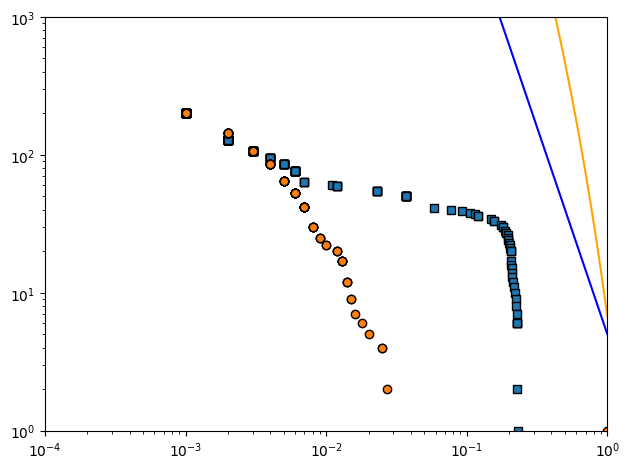

In [88]:
#Two* runs for cumulative distributions in figure 3
#grid of mean and degree variations
N = 1000
MEAN = 0.17
STANDARD_DEVIATION = 0.05
avg_degrees = [1.05, 7]
point_style = ['s', 'o']
#model_data_low, _, cascade_sizes_low = run_config(N, avg_degrees[0], MEAN, STANDARD_DEVIATION, "homogonous", "random_uniform", record_cascade=True)
#model_data_high, _, cascade_sizes_high = run_config(N, avg_degrees[1], MEAN, STANDARD_DEVIATION, "homogonous", "random_uniform", record_cascade=True)
#cascade_sizes_high

##TODO plot both cumulative distributions in loglog plot with (x=N>0 and y=0.0001>1)
for i,z in enumerate(avg_degrees):
    model_data_low, _, cascade_sizes = run_config(N, z, MEAN, STANDARD_DEVIATION, "homogonous", "random_uniform", record_cascade=True)
    sorted_cascade_sizes = sorted(cascade_sizes)
    print(sorted_cascade_sizes)
    cumulative_propability = [sum(s>=x for s in sorted_cascade_sizes) for x in sorted_cascade_sizes]
    plt.loglog(sorted_cascade_sizes, cumulative_propability, point_style[i], markeredgecolor='black')

plt.xlim([0.0001, 1])
plt.ylim([1, N])
plt.tight_layout()
plt.show()

In [14]:
#Three configuration runs for figure 4 a)
#grid of mean and degree variations
N = 1000
mean_list = np.linspace(0.05, 0.4, 12)
avg_degree_list = np.linspace(0, 30, 12, dtype=int)

STANDARD_DEVIATION = 0.05
mean_degree_matrix_std_1 = create_model_matrix(N, avg_degree_list, mean_list, STANDARD_DEVIATION, "normal", "random_uniform")

STANDARD_DEVIATION = 0.1
mean_degree_matrix_std_2 = create_model_matrix(N, avg_degree_list, mean_list, STANDARD_DEVIATION, "normal", "random_uniform")

mean_degree_matrix_hom = create_model_matrix(N, avg_degree_list, mean_list, STANDARD_DEVIATION, "homogonous", "random_uniform")

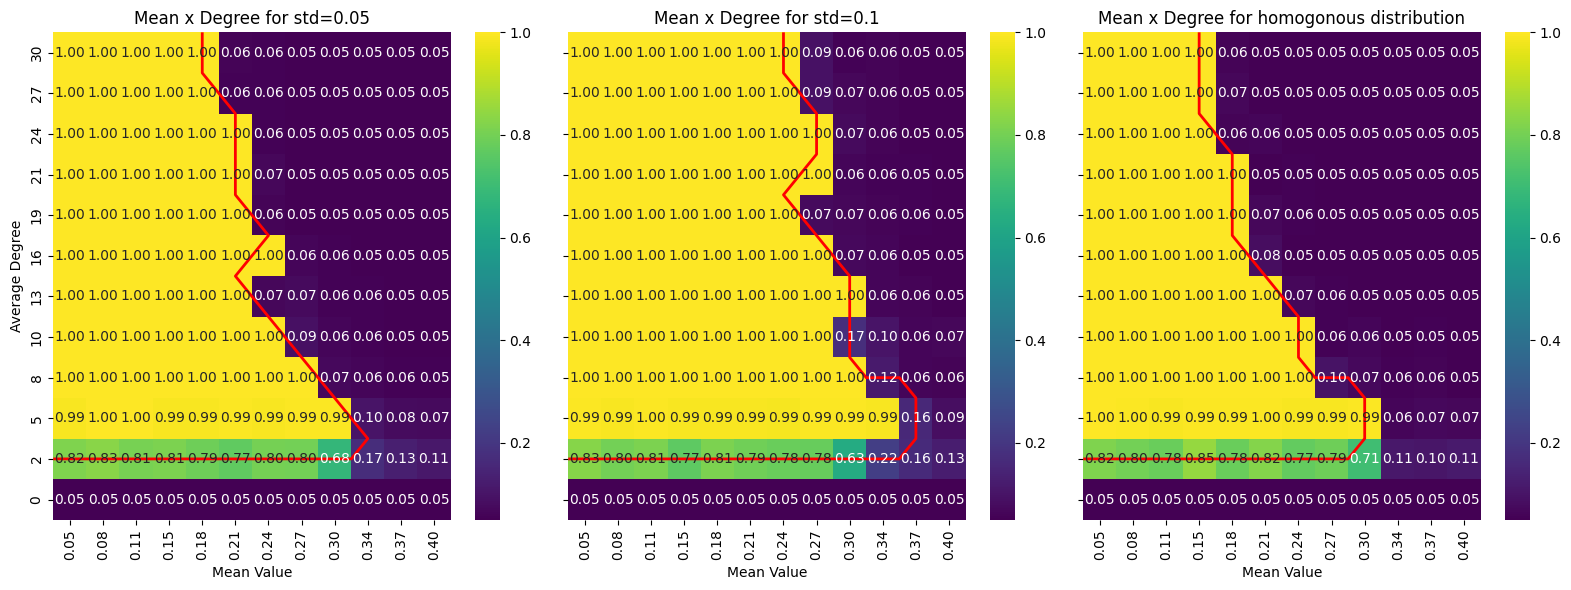

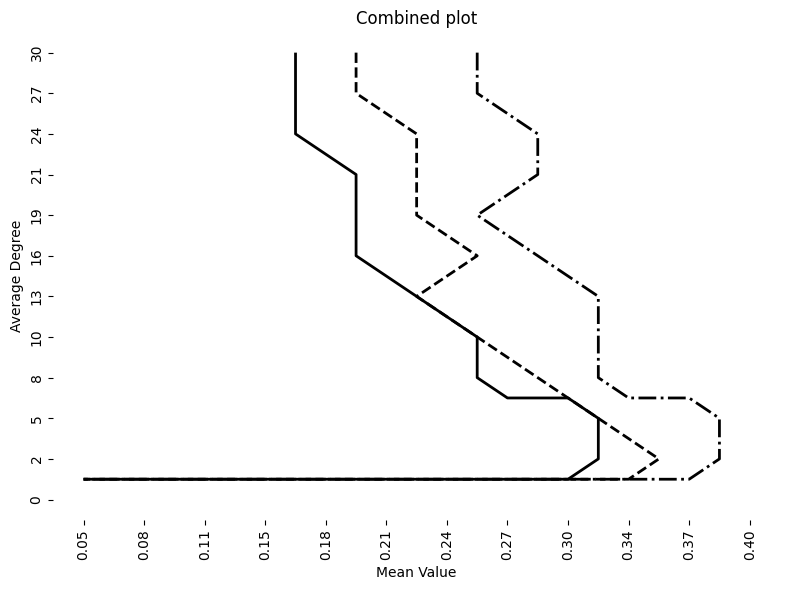

In [ ]:
#figure creation for figure 4 a)
matrices = [mean_degree_matrix_std_1, mean_degree_matrix_std_2, mean_degree_matrix_hom]
titles = ["Mean x Degree for std=0.05", "Mean x Degree for std=0.1", "Mean x Degree for homogonous distribution"]
line_types = ["dashed", "dashdot", "solid"]
THRESHOLD = 0.15

fig, axs = plt.subplots(1, 3, figsize=(16,6), sharey=True)

for i, ax in enumerate(axs):
    flipped_matrix = matrices[i].T[::-1, :]
    degree_values_flipped = avg_degree_list[::-1]
    g = sns.heatmap(flipped_matrix, ax=ax,
                    xticklabels=mean_list, 
                    yticklabels=degree_values_flipped,
                    cmap="viridis", annot=True, fmt=".2f")
    
    X, Y = np.meshgrid(range(flipped_matrix.shape[1]), range(flipped_matrix.shape[0]))
    ax.contour(X, Y, flipped_matrix >= THRESHOLD, levels=[0.5], colors='red', linewidths=2)
    
    g.set_xticklabels([f"{x:.2f}" for x in mean_list])
    ax.set_xlabel("Mean Value")
    if i == 0:
        ax.set_ylabel("Average Degree")
    else:
        ax.set_ylabel("")
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
flipped_matrix = matrices[0].T[::-1, :]
degree_values_flipped = avg_degree_list[::-1]
ax = sns.heatmap(flipped_matrix,
                 xticklabels=mean_list, 
                 yticklabels=degree_values_flipped,
                 cmap="Greys", annot=False, fmt=".2f", alpha=0.0, cbar=False)

for i, matrix in enumerate(matrices):
    flipped_matrix = matrix.T[::-1, :]
    degree_values_flipped = avg_degree_list[::-1]
    bool_mask = flipped_matrix >= THRESHOLD
    
    X, Y = np.meshgrid(np.arange(flipped_matrix.shape[1]),
                       np.arange(flipped_matrix.shape[0]))
    contour = plt.contour(X+0.5, Y+0.5, bool_mask.astype(float), levels=[0.5], 
                          colors='black', linewidths=2, linestyles=line_types[i])

ax.set_xticklabels([f"{x:.2f}" for x in mean_list])
plt.xlabel("Mean Value")
plt.ylabel("Average Degree")
plt.title("Combined plot")
plt.tight_layout()
plt.show()

simulating for figure 4b

In [82]:
#Two configuration runs for figure 4 b)
#grid of mean and degree variations
N = 1000
mean_list = np.linspace(0.1, 0.4, 10)
avg_degree_list = np.linspace(1, 20, 10, dtype=int)

mean_degree_matrix_scale_free_graph = create_model_matrix(N, avg_degree_list, mean_list, STANDARD_DEVIATION, "homogonous", "scale_free", perturb_prob=0.01)
mean_degree_matrix_uniform_graph = create_model_matrix(N, avg_degree_list, mean_list, STANDARD_DEVIATION, "homogonous", "random_uniform", perturb_prob=0.01)

TODO explain difficulties but still noticeable differences (Here or below)

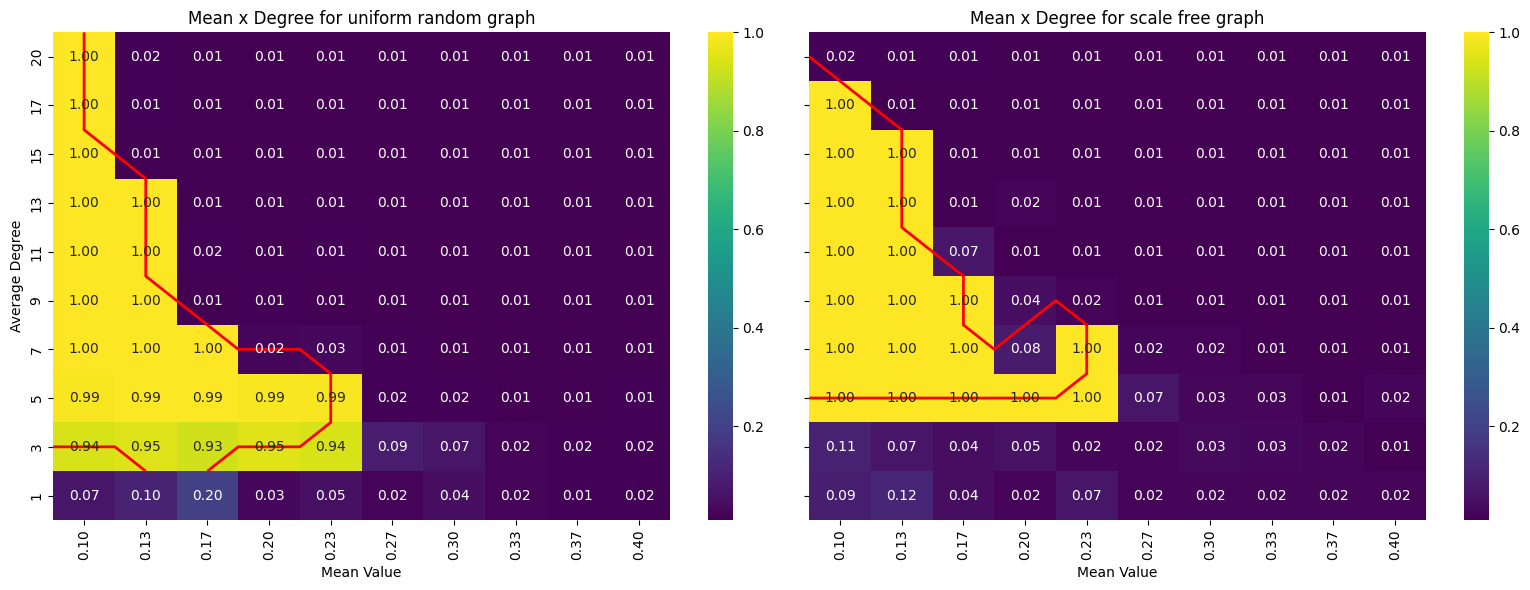

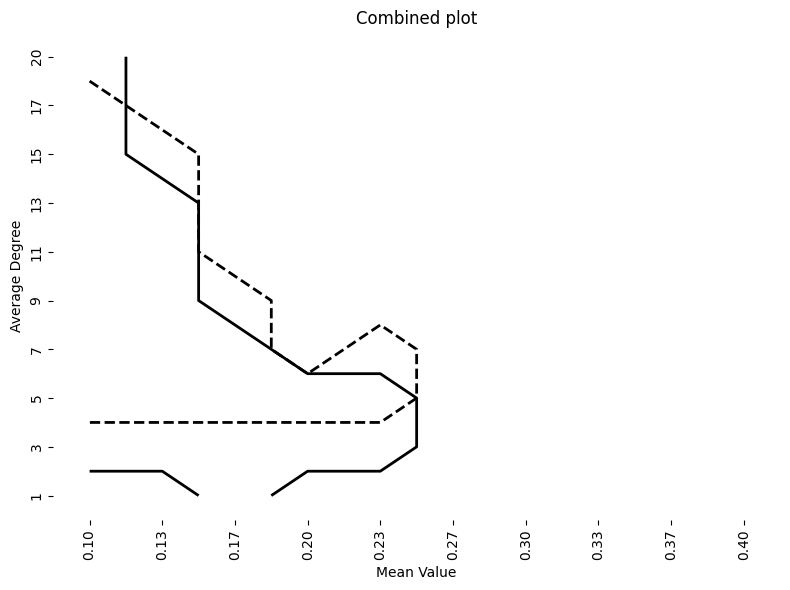

In [83]:
#figure creation for figure 4 b)
matrices = [mean_degree_matrix_uniform_graph, mean_degree_matrix_scale_free_graph]
titles = ["Mean x Degree for uniform random graph", "Mean x Degree for scale free graph"]
line_types = ["solid", "dashed"]
THRESHOLD = 0.15

fig, axs = plt.subplots(1, 2, figsize=(16,6), sharey=True)

for i, ax in enumerate(axs):
    flipped_matrix = matrices[i].T[::-1, :]
    degree_values_flipped = avg_degree_list[::-1]
    g = sns.heatmap(flipped_matrix, ax=ax,
                    xticklabels=mean_list, 
                    yticklabels=degree_values_flipped,
                    cmap="viridis", annot=True, fmt=".2f")
    
    X, Y = np.meshgrid(range(flipped_matrix.shape[1]), range(flipped_matrix.shape[0]))
    ax.contour(X, Y, flipped_matrix >= THRESHOLD, levels=[0.5], colors='red', linewidths=2)
    
    g.set_xticklabels([f"{x:.2f}" for x in mean_list])
    ax.set_xlabel("Mean Value")
    if i == 0:
        ax.set_ylabel("Average Degree")
    else:
        ax.set_ylabel("")
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
flipped_matrix = matrices[0].T[::-1, :]
degree_values_flipped = avg_degree_list[::-1]
ax = sns.heatmap(flipped_matrix,
                 xticklabels=mean_list, 
                 yticklabels=degree_values_flipped,
                 cmap="Greys", annot=False, fmt=".2f", alpha=0.0, cbar=False)

for i, matrix in enumerate(matrices):
    flipped_matrix = matrix.T[::-1, :]
    degree_values_flipped = avg_degree_list[::-1]
    bool_mask = flipped_matrix >= THRESHOLD
    
    X, Y = np.meshgrid(np.arange(flipped_matrix.shape[1]),
                       np.arange(flipped_matrix.shape[0]))
    contour = plt.contour(X+0.5, Y+0.5, bool_mask.astype(float), levels=[0.5], 
                          colors='black', linewidths=2, linestyles=line_types[i])

ax.set_xticklabels([f"{x:.2f}" for x in mean_list])
plt.xlabel("Mean Value")
plt.ylabel("Average Degree")
plt.title("Combined plot")
plt.tight_layout()
plt.show()